In [105]:
sourcelist = """Ai	19:02:47.9904	05:29:21.3746
Aii	19:00:36.9730	04:13:18.5048
Aiii	19:00:37.030793	04:14:59.16581
Bii	18:53:21.3819 	-00:29:04.2697
Ci	18:52:24.2948	-00:30:29.5635
Di	18:48:48.0931	-01:39:54.6867
Dii	18:47:37.2727	-02:18:50.7242
Ei	18:44:51.4623	-02:20:05.8099
Eii	18:46:42.04926	-03:00:24.3309
Fii	18:46:14.0720	-03:11:40.5391
Gii	18:45:04.2989	-03:22:49.6816
Hi	18:45:00.3479	-03:28:25.6209
Hii	18:44:47.2874	-03:59:36.4665
Ii	18:41:33.2881	-04:24:33.0908
Iii	18:38:26.3637	-05:48:35.1326
Lii	18:36:32.3808	-07:31:33.5737
Mi	18:34:33.0479	-08:15:26.9669"""

In [106]:
import warnings
warnings.simplefilter('ignore')

In [107]:
from astropy import units as u
from astropy import coordinates

In [108]:
sources = [x.split("\t") for x in sourcelist.split("\n")]
sourcecrds = {x[0]: coordinates.SkyCoord(x[1], x[2], unit=(u.h, u.deg), frame='fk5') for x in sources}
sourcecrds

{'Ai': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (285.69996, 5.48927072)>,
 'Aii': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (285.15405417, 4.22180689)>,
 'Aiii': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (285.15429497, 4.24976828)>,
 'Bii': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (283.33909125, -0.48451936)>,
 'Ci': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (283.10122833, -0.50821208)>,
 'Di': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (282.20038792, -1.66519075)>,
 'Dii': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (281.90530292, -2.31409006)>,
 'Ei': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (281.21442625, -2.33494719)>,
 'Eii': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (281.67520525, -3.00675858)>,
 'Fii': <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
     (281.55863333, -3.19459419)>,
 'Gii': <SkyCoord (FK5: equinox=J2000.000): (ra, 

In [109]:
import numpy as np
import os
import pylab as pl
import reproject

from astroquery.magpis import Magpis
from astroquery.herschel.higal import HiGal
from astroquery.ukidss import Ukidss
from astropy import units as u, coordinates
from astropy.nddata import Cutout2D
from astropy.io import fits
from astropy import wcs
from astropy import visualization

import matplotlib as mpl

basepath = '/orange/adamginsburg/experiments/pikkyvlba/'

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False
mpl.rcParams['figure.facecolor'] = 'w'


def getimg(*args, **kwargs):
    try:
        return Magpis.get_images(*args, **kwargs)
    except:
        return

wlmap = {'gps6': 6*u.cm,
         'gps6epoch2': 6*u.cm,
         'gps6epoch3': 6*u.cm,
         'gps6epoch4': 6*u.cm,
         'gps20': 20*u.cm,
         'gps20new': 20*u.cm,
         'gps90': 90*u.cm,
         'gpsmsx': 8*u.um,
         'gpsmsx2': 8*u.um,
         'gpsglimpse36': 3.6*u.um,
         'gpsglimpse45': 4.5*u.um,
         'gpsglimpse58': 5.8*u.um,
         'gpsglimpse80': 8.0*u.um,
         'mipsgal': 24*u.um,
         'atlasgal': 0.870*u.mm,
         'bolocam': 1.1*u.mm,
         'mgps': 3.*u.mm,
         'HiGal70': 70*u.um,
         'HiGal160': 160*u.um,
         'HiGal250': 250*u.um,
         'HiGal350': 350*u.um,
         'HiGal500': 500*u.um,
         'UKIDSS_J': 1*u.um,
         'UKIDSS_H': 1.6*u.um,
         'UKIDSS_K': 2.2*u.um
         }

survey_titles = {'gps6': 'MAGPIS Epoch 1',
                 'gps6epoch2': 'MAGPIS Epoch 2',
                 'gps6epoch3': 'MAGPIS Epoch 3',
                 'gps6epoch4': 'MAGPIS Epoch 4',
                 'gps20': "MAGPIS",
                 'gps20new': "MAGPIS New",
                 'gps90': "VLA",
                 'gpsmsx': "MSX",
                 'gpsmsx2': "MSX 2",
                 'gpsglimpse36': "GLIMPSE",
                 'gpsglimpse45': "GLIMPSE",
                 'gpsglimpse58': "GLIMPSE",
                 'gpsglimpse80': "GLIMPSE",
                 'mipsgal': "MIPSGAL",
                 'atlasgal': "ATLASGAL",
                 'bolocam': "BGPS",
                 'mgps': "$\mathbf{MGPS-90}$",
                 'HiGal70':  "Hi-Gal",
                 'HiGal160': "Hi-Gal",
                 'HiGal250': "Hi-Gal",
                 'HiGal350': "Hi-Gal",
                 'HiGal500': "Hi-Gal",
                 'UKIDSS_J': 'UKIDSS J',
                 'UKIDSS_H': 'UKIDSS H',
                 'UKIDSS_K': 'UKIDSS K',
                 }

def make_sed_plot(coordinate, width=1*u.arcmin, surveys=Magpis.list_surveys(), figure=None,
                  higaldir='/orange/adamginsburg/higal/'):


    coordname = "{0:06.3f}_{1:06.3f}".format(coordinate.galactic.l.deg,
                                             coordinate.galactic.b.deg)

    print(f"Retrieving MAGPIS data for {coordname} ({coordinate.to_string()} {coordinate.frame.name})")
    # we're treating 'width' as a radius elsewhere, here it's a full width
    images = {survey:getimg(coordinate, image_size=width*2.75, survey=survey) for survey in surveys}
    images = {x:y for x,y in images.items() if y is not None}
    
    # retrieve UKIDSS
    print("Retrieving UKIDSS data")
    ukims = Ukidss.get_images(coordinate, image_width=3*width)
    images.update({f'UKIDSS_{f[0].header["FILTER"]}': f for f in ukims})

    regdir = os.path.join(basepath, "regions")
    if not os.path.exists(regdir):
        os.mkdir(regdir)
    higaldir = os.path.join(basepath, 'HiGalCutouts')
    if not os.path.exists(higaldir):
        os.mkdir(higaldir)
    if not any([os.path.exists(f"{higaldir}/{coordname}_{wavelength}.fits")
                for wavelength in map(int, HiGal.HIGAL_WAVELENGTHS.values())]):
        print(f"Retrieving HiGal data for {coordname} ({coordinate.to_string()} {coordinate.frame.name})")
        higal_ims = HiGal.get_images(coordinate, radius=width*1.5)
        for hgim in higal_ims:
            images['HiGal{0}'.format(hgim[0].header['WAVELEN'])] = hgim
            hgim.writeto(f"{higaldir}/{coordname}_{hgim[0].header['WAVELEN']}.fits")
    else:
        print(f"Loading HiGal data from disk for {coordname} ({coordinate.to_string()} {coordinate.frame.name})")
        for wavelength in map(int, HiGal.HIGAL_WAVELENGTHS.values()):
            hgfn = f"{higaldir}/{coordname}_{wavelength}.fits"
            if os.path.exists(hgfn):
                hgim = fits.open(hgfn)
                images['HiGal{0}'.format(hgim[0].header['WAVELEN'])] = hgim

    if 'gpsmsx2' in images:
        # redundant, save some space for a SED plot
        del images['gpsmsx2']
    if 'gps90' in images:
        # too low-res to be useful
        del images['gps90']

    for key in images:
        cutout = images[key]
        if not hasattr(cutout, 'wcs'):
            try:
                cutout.wcs = wcs.WCS(cutout[1].header)
            except IndexError:
                cutout.wcs = wcs.WCS(cutout[0].header)
                
        
    # coordinate stuff so images can be reprojected to same frame
    ww = cutout.wcs.celestial
    target_header = ww.to_header()
    if 'LONPOLE' in target_header:
        del target_header['LONPOLE']
        del target_header['LATPOLE']
    pixscale = (wcs.utils.proj_plane_pixel_area(ww)*u.deg**2)**0.5
    target_header['NAXES'] = 2
    target_header['NAXIS1'] = target_header['NAXIS2'] = (width / pixscale).decompose().value
    #shape = [int((width / mgps_pixscale).decompose().value)]*2
    outframe = wcs.utils.wcs_to_celestial_frame(ww)
    crd_outframe = coordinate.transform_to(outframe)


    imagelist = sorted(images.items(), key=lambda x: wlmap[x[0]])

    if figure is None:
        figure = pl.figure(figsize=(15,12))    
    figure.clf()
    
    #for ii, (survey,img) in enumerate(images.items()):
    for ii, (survey,img) in enumerate(imagelist):

        if hasattr(img[0], 'header'):
            if img[0].data is None:
                data = img[1].data
                header = img[1].header
            else:
                data = img[0].data
                header = img[0].header
            inwcs = wcs.WCS(header).celestial
            pixscale_in = (wcs.utils.proj_plane_pixel_area(inwcs)*u.deg**2)**0.5

            target_header['CDELT1'] = -pixscale_in.value
            target_header['CDELT2'] = pixscale_in.value
            target_header['CRVAL1'] = crd_outframe.spherical.lon.deg
            target_header['CRVAL2'] = crd_outframe.spherical.lat.deg
            axsize = int((width*2.5 / pixscale_in).decompose().value)
            target_header['NAXIS1'] = target_header['NAXIS2'] = axsize
            target_header['CRPIX1'] = target_header['NAXIS1']/2
            target_header['CRPIX2'] = target_header['NAXIS2']/2
            shape_out = [axsize, axsize]

            print(f"Reprojecting {survey} to scale {pixscale_in} with shape {shape_out} and center {crd_outframe.to_string()}")

            outwcs = wcs.WCS(target_header)

            new_img,_ = reproject.reproject_interp((data, inwcs), target_header, shape_out=shape_out)
        else:
            new_img = img[0].data
            outwcs = img[0].wcs
            pixscale_in = (wcs.utils.proj_plane_pixel_area(outwcs)*u.deg**2)**0.5

        if len(imagelist) > 20:
            ax = figure.add_subplot(4, 6, ii+1, projection=outwcs)
        else:
            ax = figure.add_subplot(4, 5, ii+1, projection=outwcs)

        ax.set_title("{0}: {1}".format(survey_titles[survey], wlmap[survey]))

        if not np.any(np.isfinite(new_img)):
            print(f"SKIPPING {survey}")
            continue

        norm = visualization.ImageNormalize(new_img,
                                            interval=visualization.PercentileInterval(99.95),
                                            stretch=visualization.AsinhStretch(),
                                           )

        ax.imshow(new_img, origin='lower', interpolation='none', norm=norm)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.xaxis.set_ticklabels('')
        ax.yaxis.set_ticklabels('')
        ax.coords[0].set_ticklabel_visible(False)
        ax.coords[1].set_ticklabel_visible(False)

        if 'GLON' in outwcs.wcs.ctype[0]:
            xpix, ypix = outwcs.wcs_world2pix(coordinate.galactic.l, coordinate.galactic.b, 0)
        else:
            xpix, ypix = outwcs.wcs_world2pix(coordinate.fk5.ra, coordinate.fk5.dec, 0)
        ax.set_xlim(xpix - (width/pixscale_in), xpix + (width/pixscale_in))
        ax.set_ylim(ypix - (width/pixscale_in), ypix + (width/pixscale_in))

        # scalebar = 1 arcmin

        ax.plot([xpix - width/pixscale_in + 5*u.arcsec/pixscale_in,
                 xpix - width/pixscale_in + 65*u.arcsec/pixscale_in],
                [ypix - width/pixscale_in + 5*u.arcsec/pixscale_in,
                 ypix - width/pixscale_in + 5*u.arcsec/pixscale_in],
                linestyle='-', linewidth=1, color='w')
        ax.plot(crd_outframe.spherical.lon.deg, crd_outframe.spherical.lat.deg, marker=((0,-10), (0, -4)), color='w', linestyle='none',
                markersize=20, markeredgewidth=0.5,
                transform=ax.get_transform('world'))
        ax.plot(crd_outframe.spherical.lon.deg, crd_outframe.spherical.lat.deg, marker=((4, 0), (10, 0)), color='w', linestyle='none',
                markersize=20, markeredgewidth=0.5,
                transform=ax.get_transform('world'))

    pl.tight_layout()
    
    return figure

Retrieving MAGPIS data for 32.590_-0.447 (283.101 -0.508212 fk5)
Retrieving UKIDSS data
Found 3 targets
Retrieving HiGal data for 32.590_-0.447 (283.101 -0.508212 fk5)
Getting image list at <SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (283.10122833, -0.50821208)> with 1.5 arcmin
Reprojecting UKIDSS_J to scale 5.570801526361518e-05 deg with shape [747, 747] and center 283.101 -0.508218
Reprojecting UKIDSS_H to scale 5.571036207898573e-05 deg with shape [747, 747] and center 283.101 -0.508218
Reprojecting UKIDSS_K to scale 5.5693991566204426e-05 deg with shape [748, 748] and center 283.101 -0.508218
Reprojecting gpsglimpse36 to scale 0.0005555560000000002 deg with shape [74, 74] and center 283.101 -0.508218
Reprojecting gpsglimpse45 to scale 0.0005555560000000002 deg with shape [74, 74] and center 283.101 -0.508218
Reprojecting gpsglimpse58 to scale 0.0005555560000000002 deg with shape [74, 74] and center 283.101 -0.508218
Reprojecting gpsmsx to scale 0.00041666699999999985 d

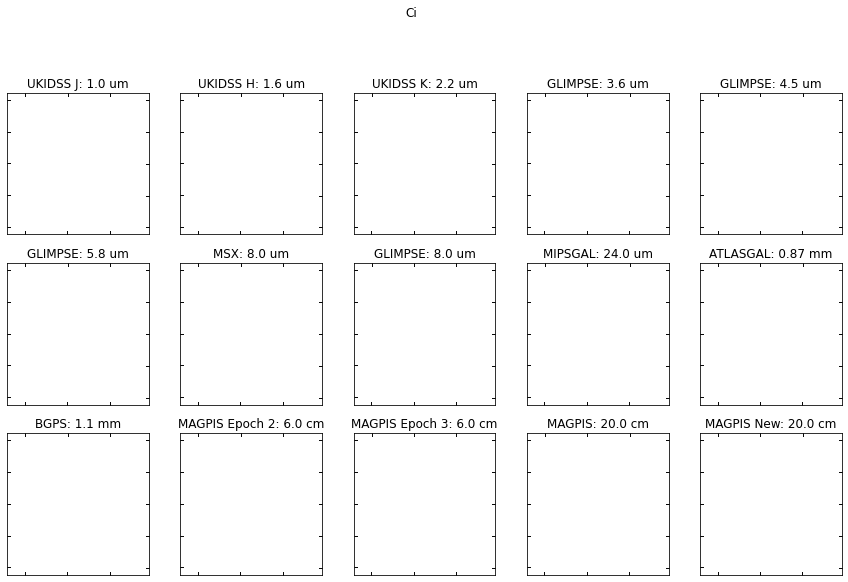

In [110]:
sourcename = 'Ci'
figure = make_sed_plot(sourcecrds[sourcename],  width=1*u.arcmin, surveys=Magpis.list_surveys(), figure=None,)
figure.suptitle(sourcename)
figure.savefig(f'/orange/adamginsburg/experiments/pikkyvlba/{sourcename}_cutouts.png')

Ai
Retrieving MAGPIS data for 39.111_-0.016 (285.7 5.48927 fk5)
Retrieving UKIDSS data
Found 6 targets
Loading HiGal data from disk for 39.111_-0.016 (285.7 5.48927 fk5)
Reprojecting UKIDSS_J to scale 5.5725552963602945e-05 deg with shape [747, 747] and center 39.1105 -0.0161774
Reprojecting UKIDSS_H to scale 5.5710827697494785e-05 deg with shape [747, 747] and center 39.1105 -0.0161774
Reprojecting UKIDSS_K to scale 5.571602429701308e-05 deg with shape [747, 747] and center 39.1105 -0.0161774
Reprojecting gpsglimpse36 to scale 0.0005555560000000002 deg with shape [74, 74] and center 39.1105 -0.0161774
Reprojecting gpsglimpse45 to scale 0.0005555560000000002 deg with shape [74, 74] and center 39.1105 -0.0161774
Reprojecting gpsglimpse58 to scale 0.0005555560000000002 deg with shape [74, 74] and center 39.1105 -0.0161774
Reprojecting gpsmsx to scale 0.00041666699999999985 deg with shape [99, 99] and center 39.1105 -0.0161774
Reprojecting gpsglimpse80 to scale 0.0005555560000000002 deg w

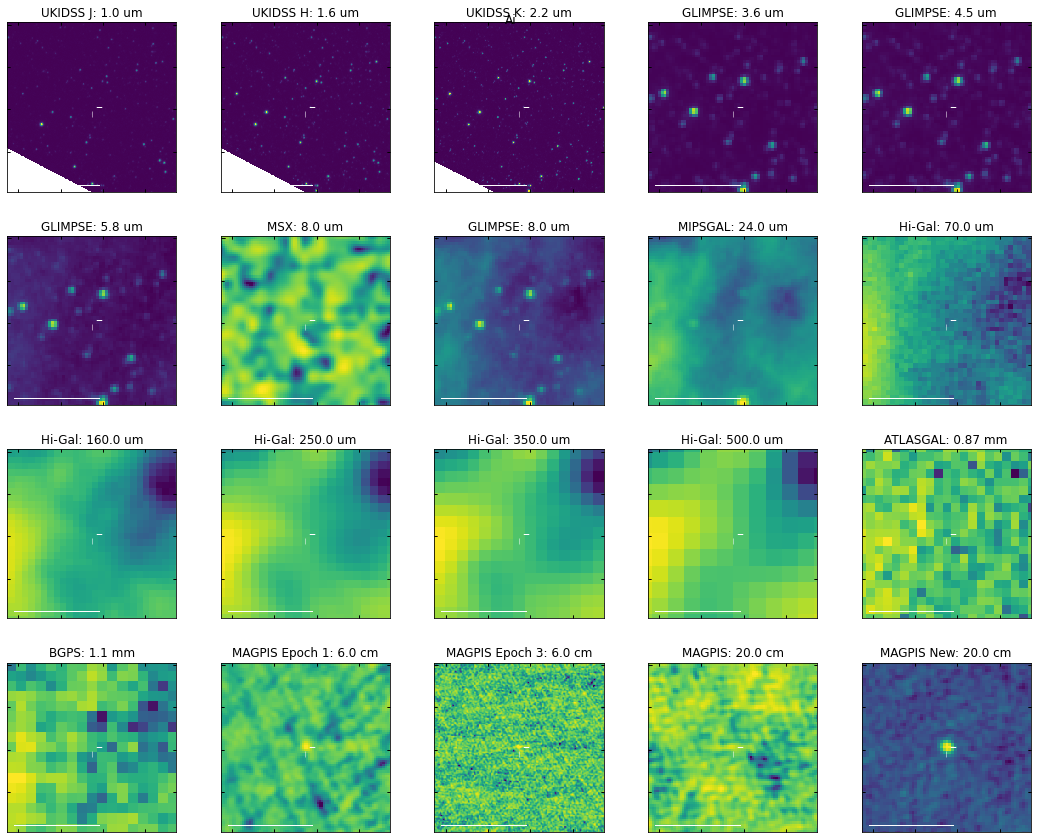

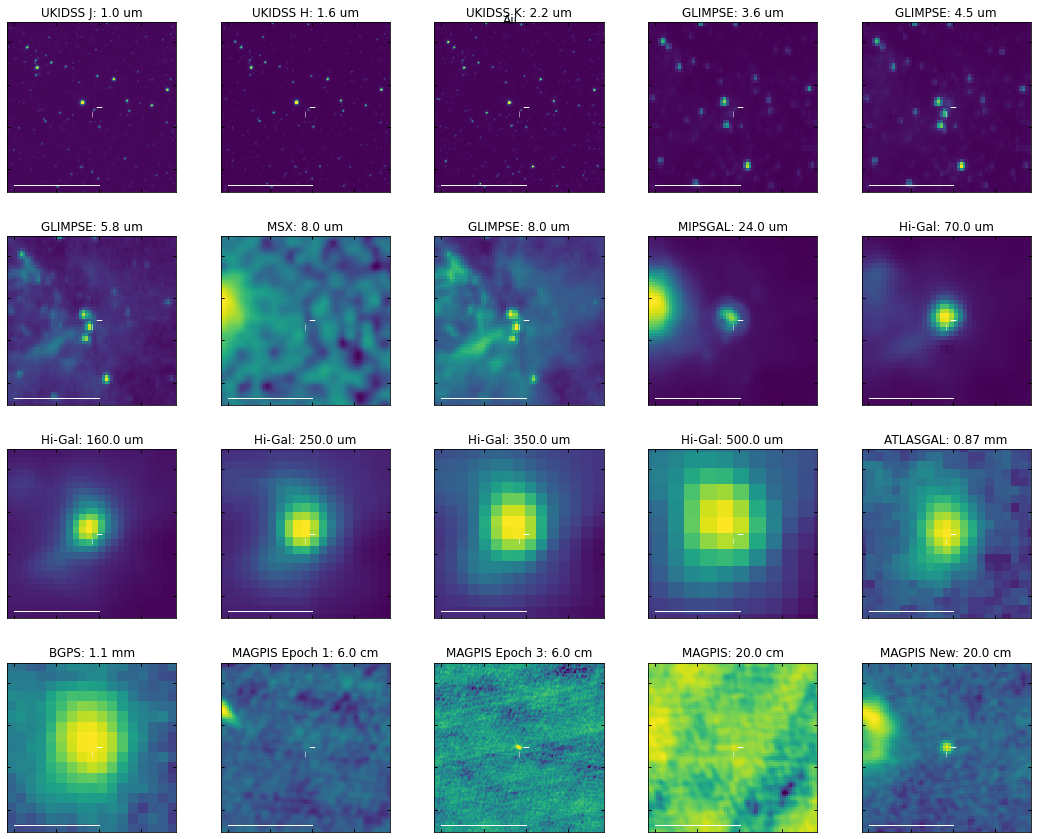

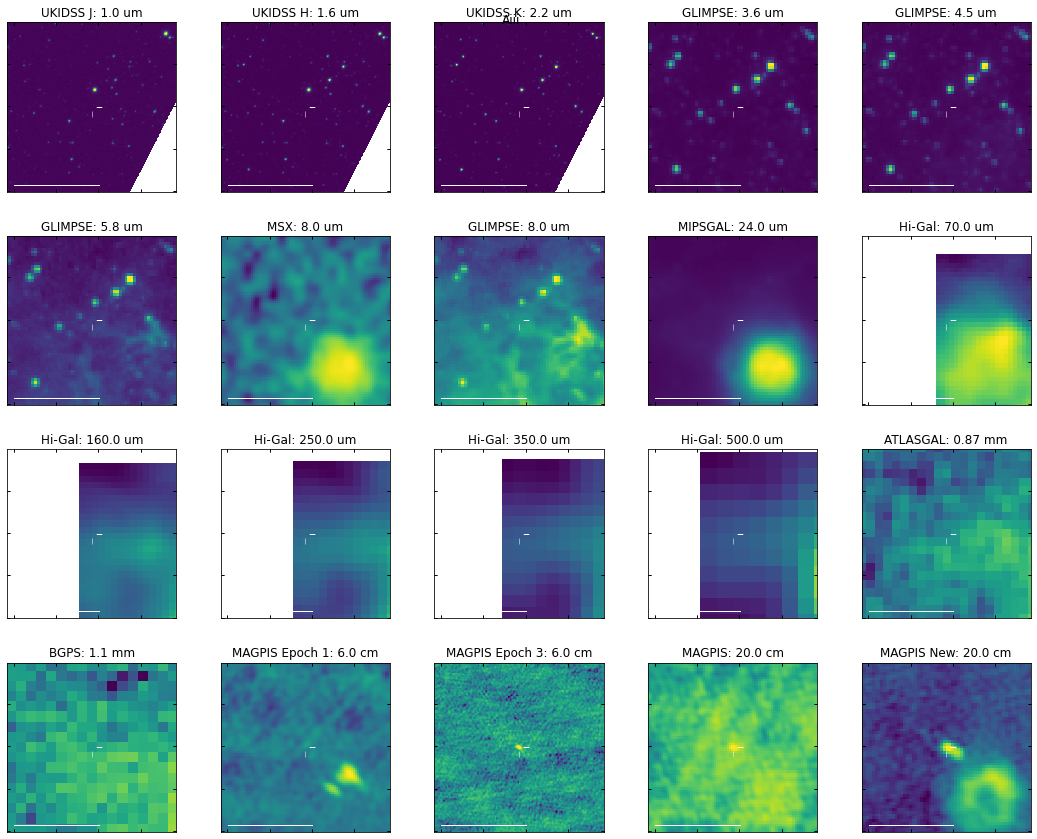

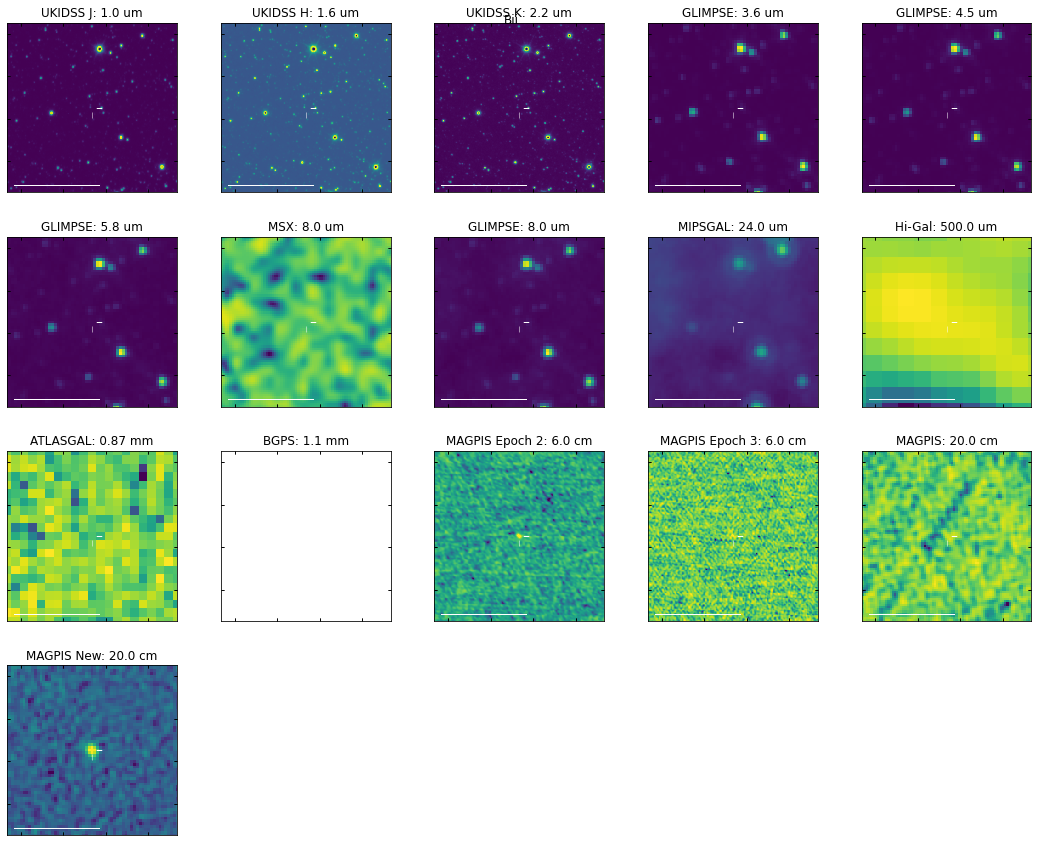

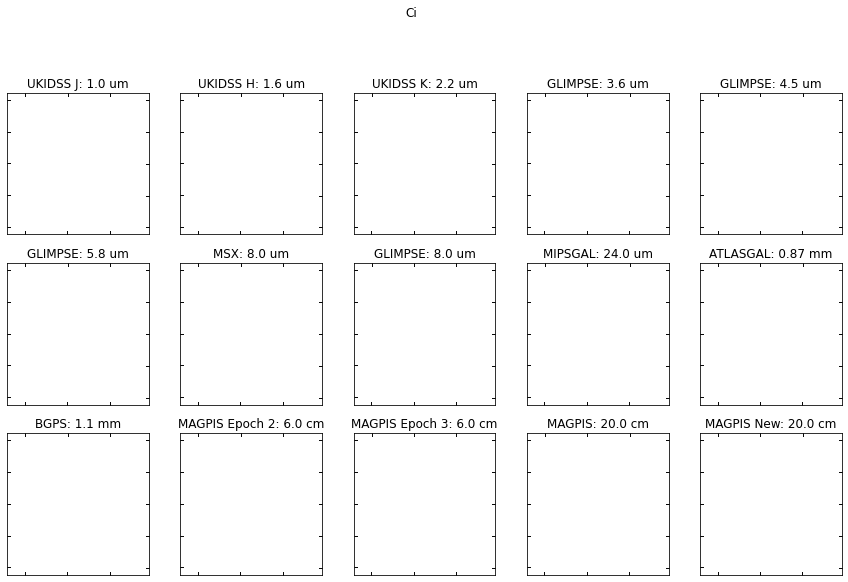

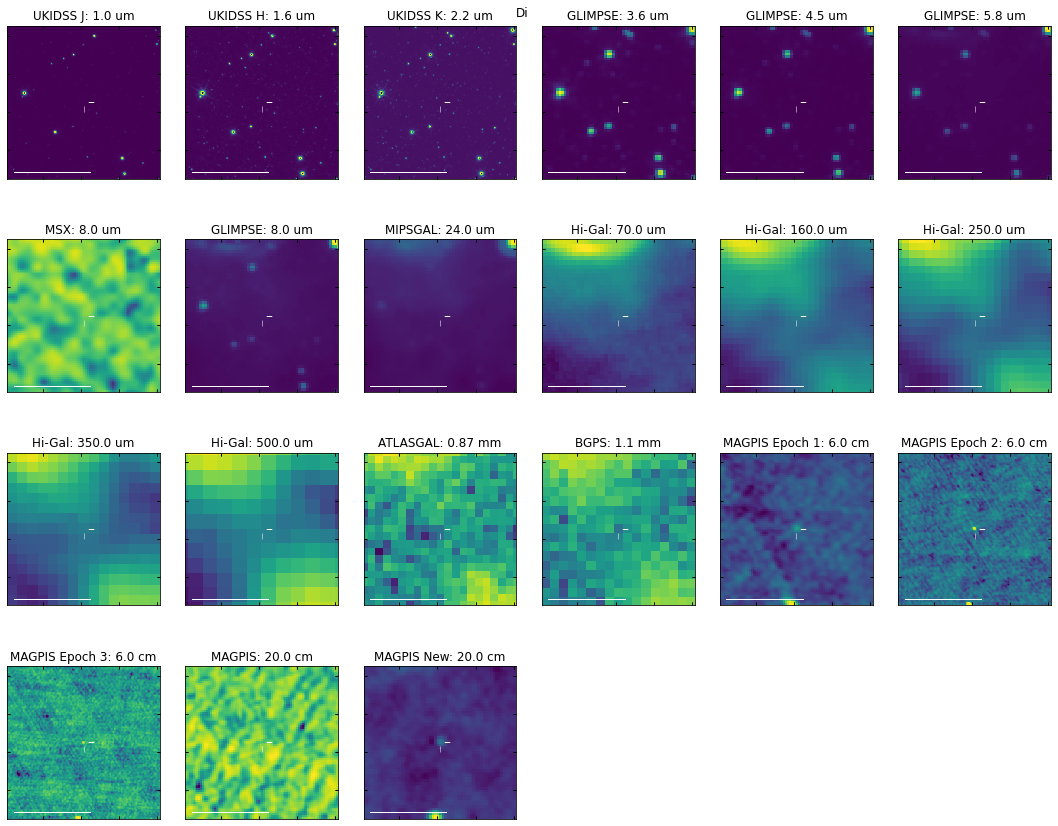

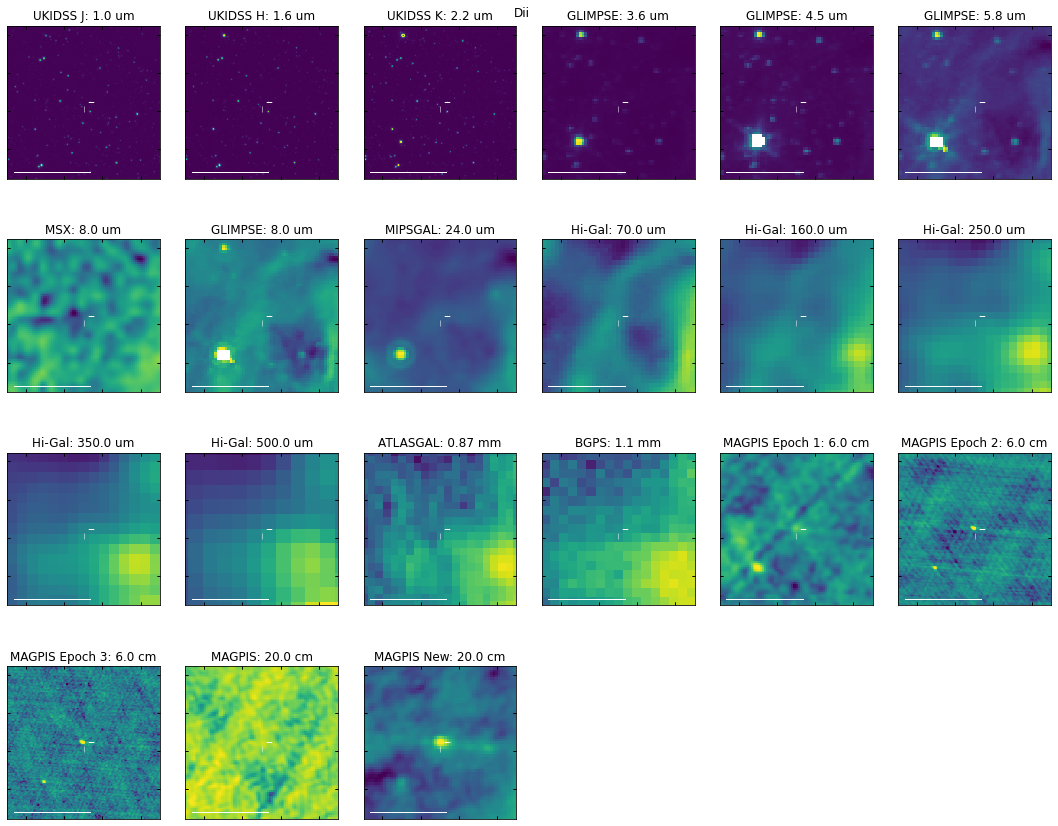

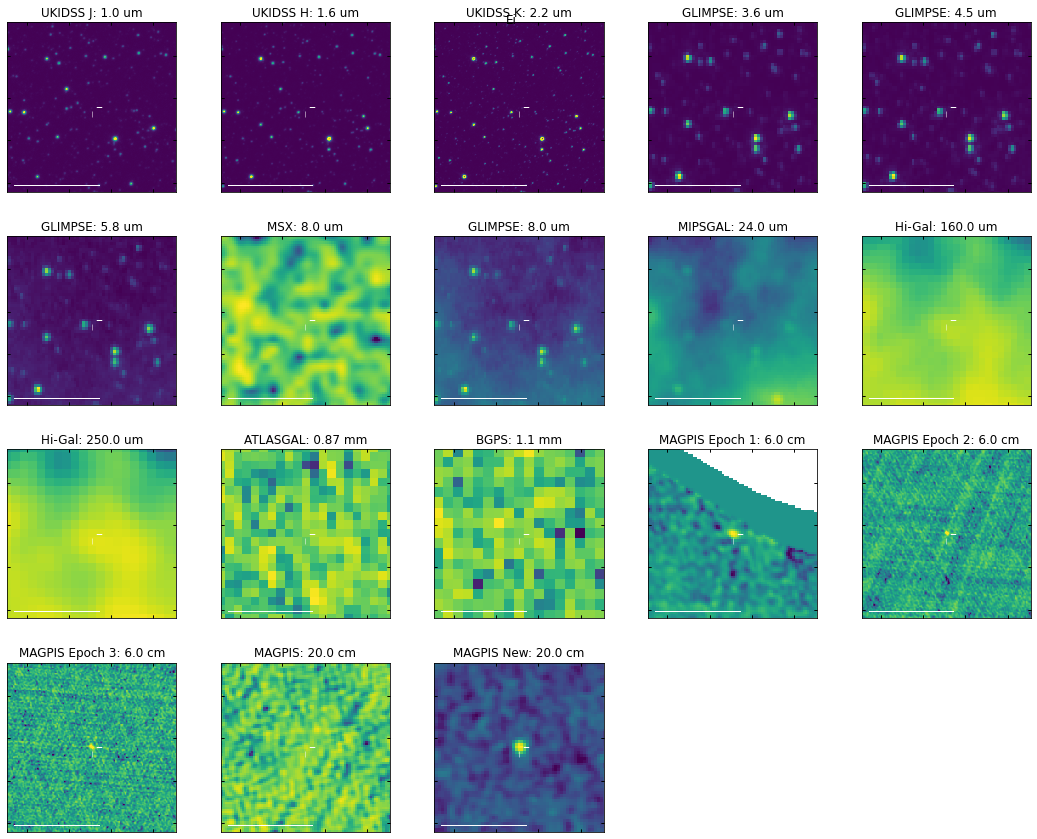

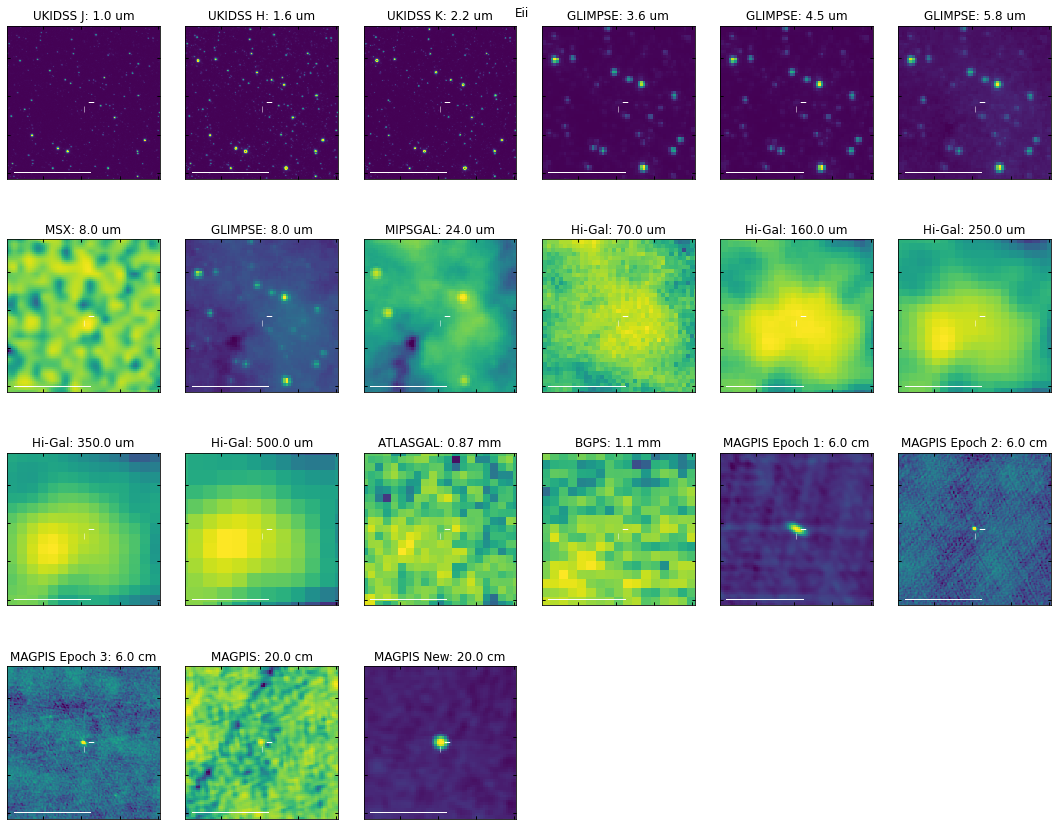

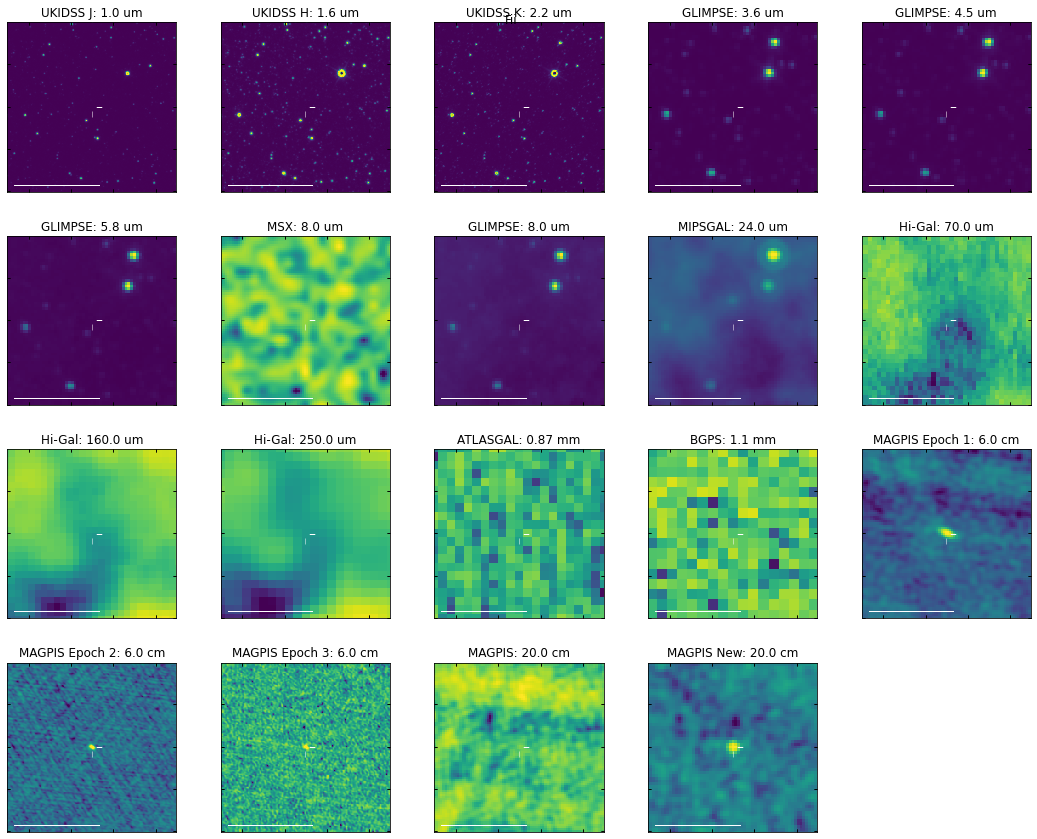

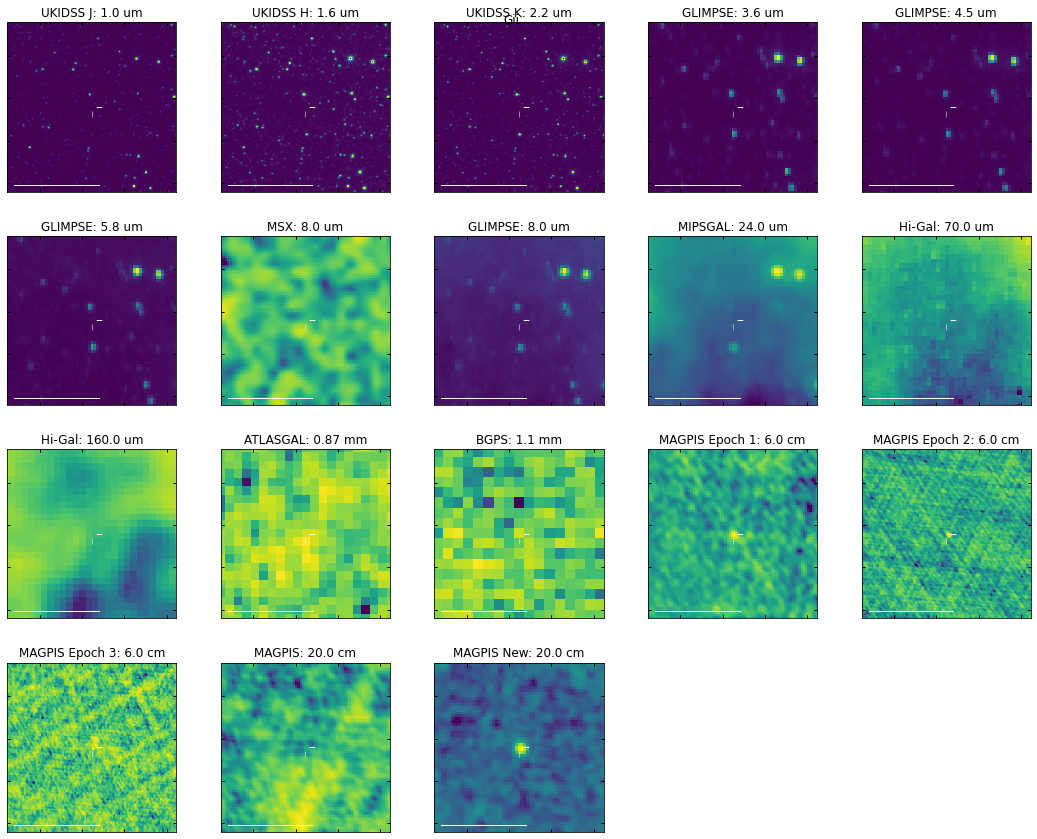

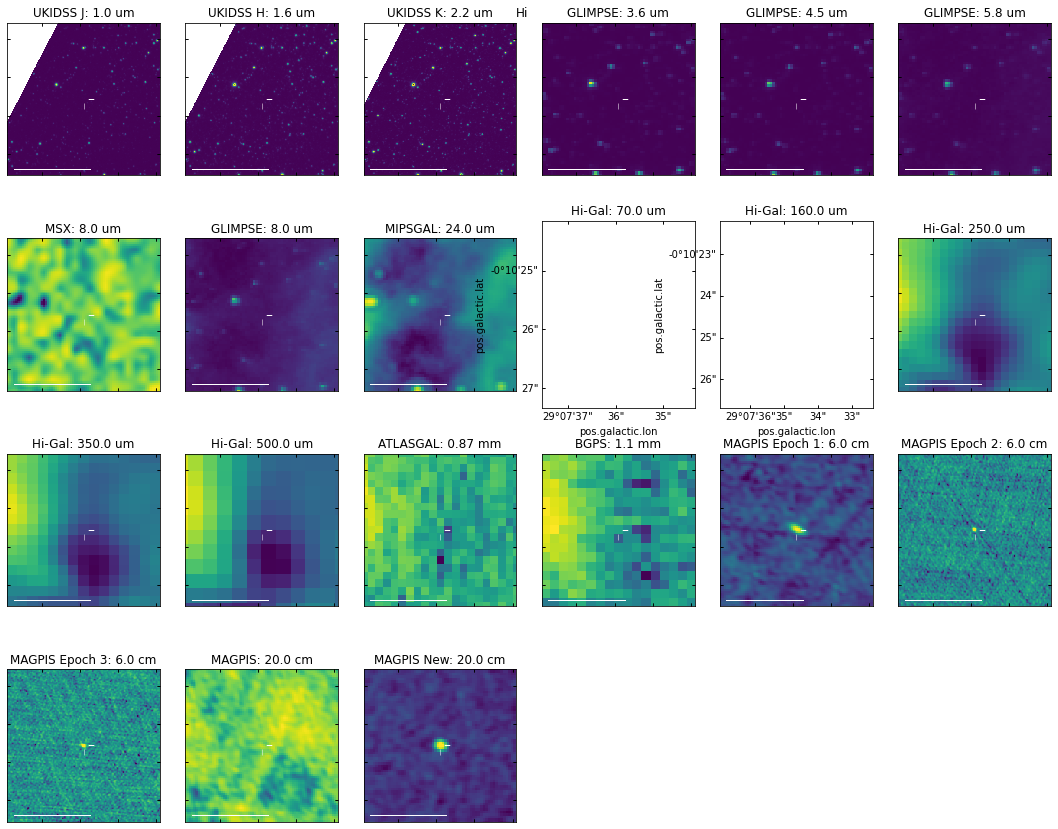

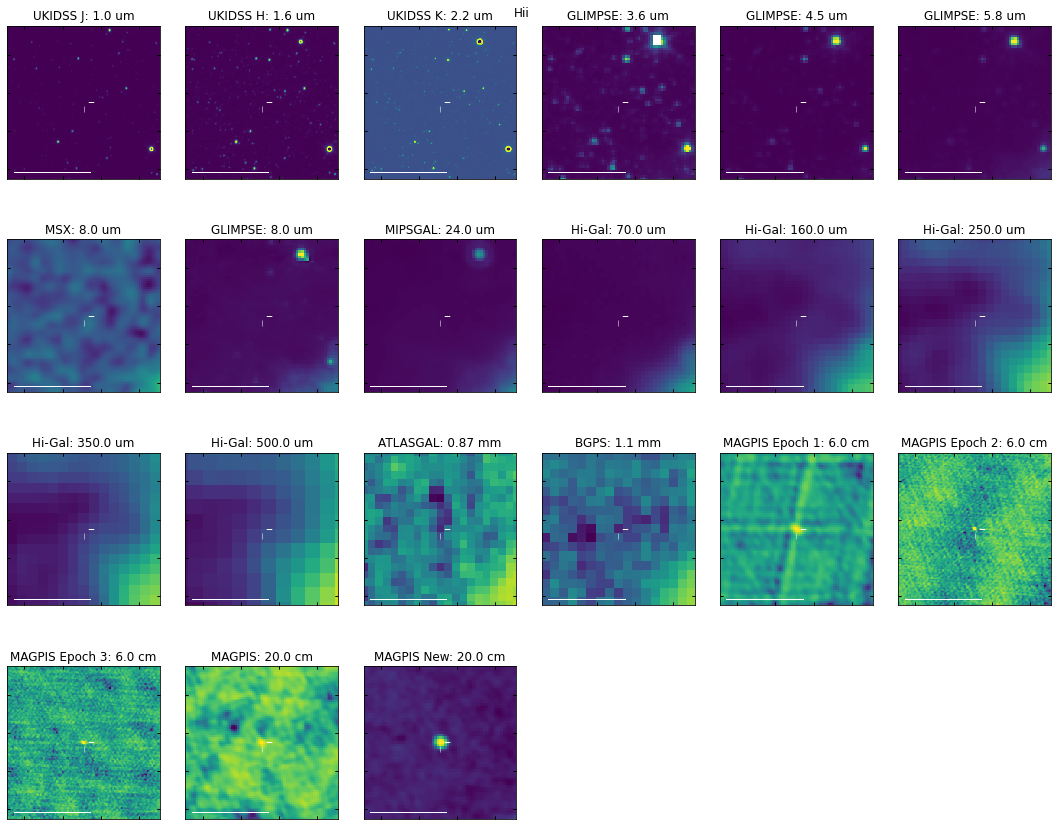

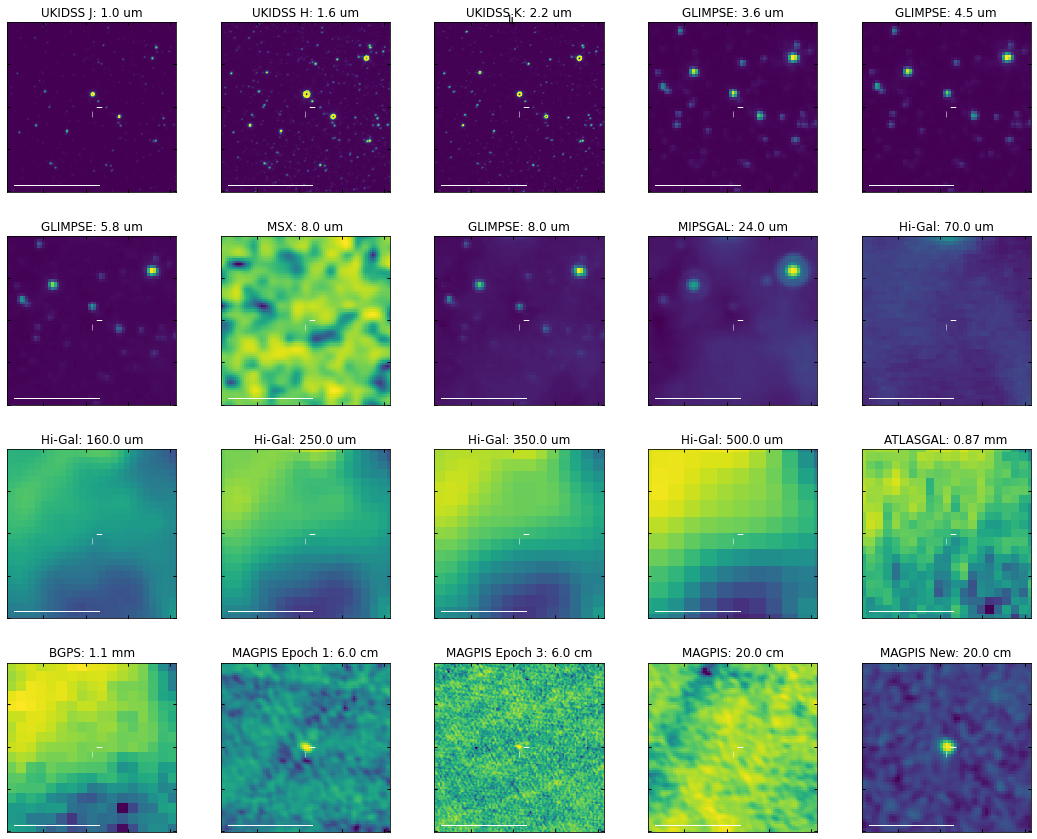

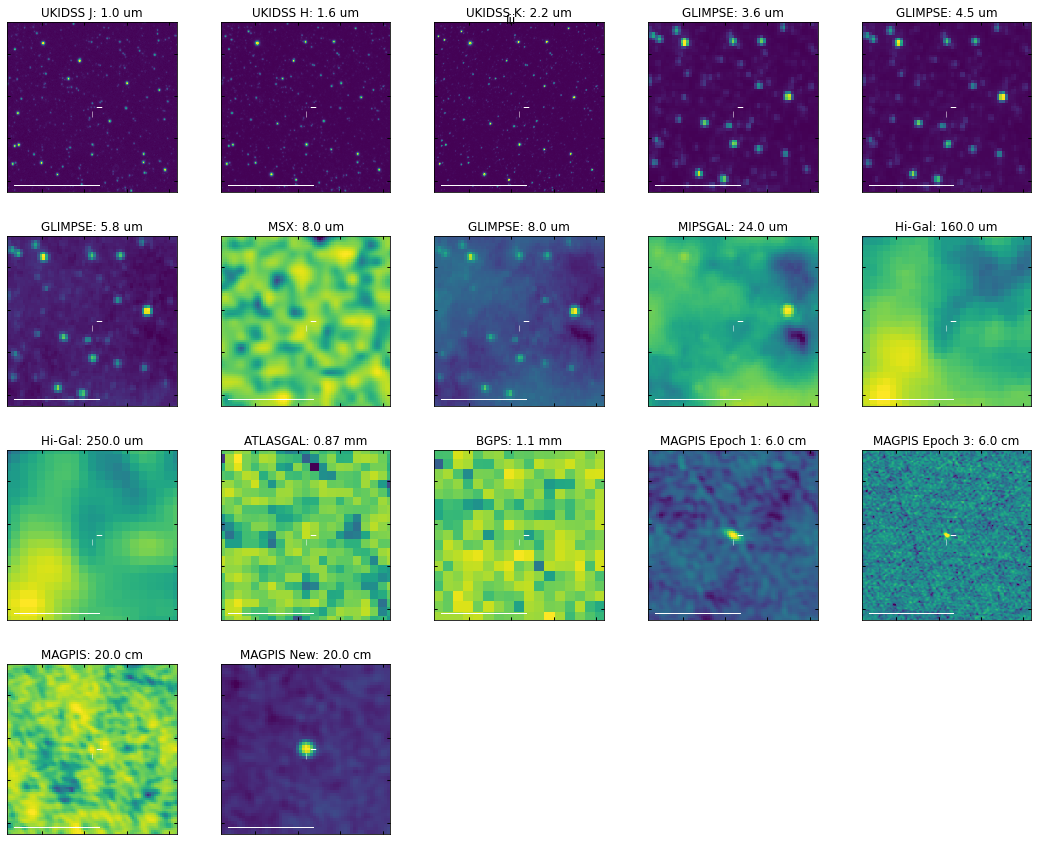

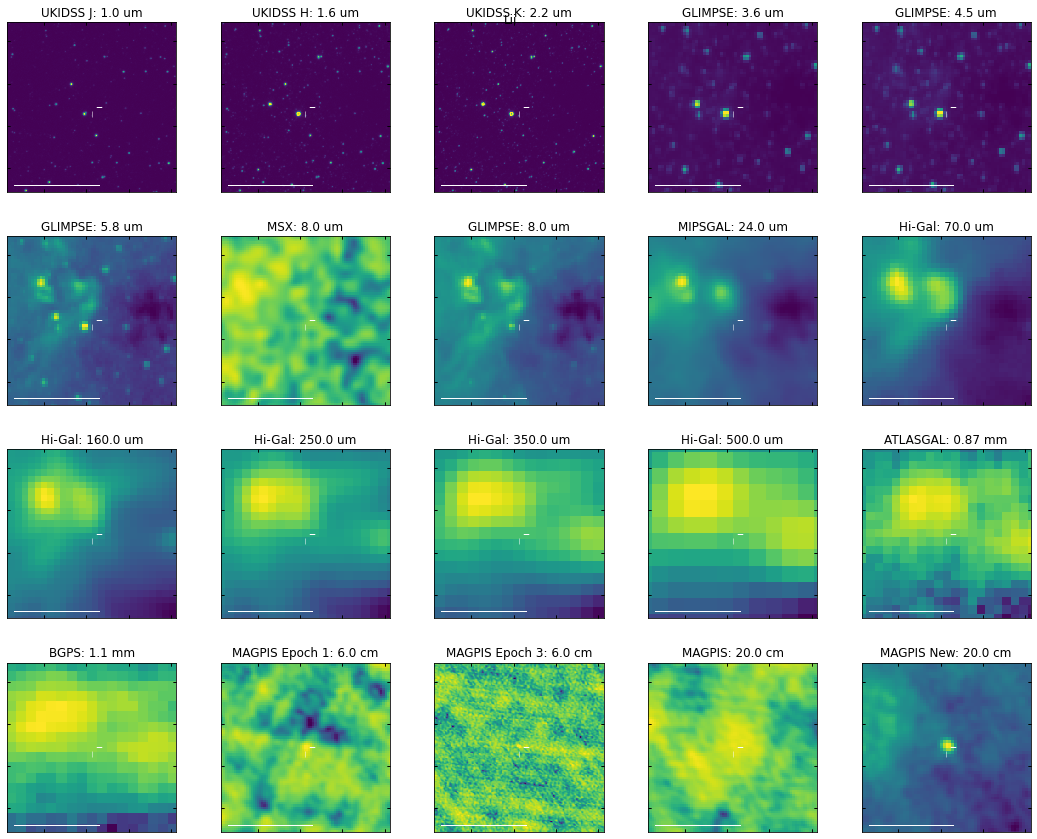

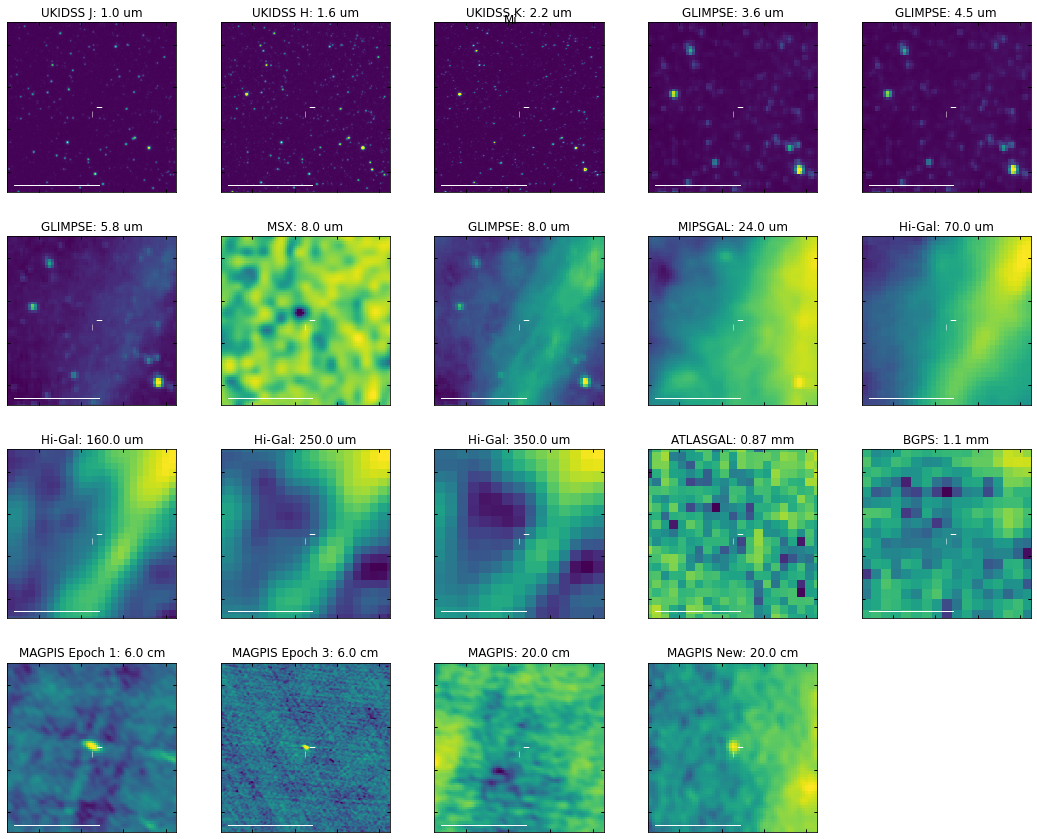

In [111]:
for sourcename in sourcecrds:
    print(sourcename)
    figure = make_sed_plot(sourcecrds[sourcename],  width=1*u.arcmin, surveys=Magpis.list_surveys(), figure=None,)
    figure.suptitle(sourcename)
    figure.savefig(f'/orange/adamginsburg/experiments/pikkyvlba/{sourcename}_cutouts.png')

In [112]:
from astroquery.simbad import Simbad

In [113]:
Simbad.list_votable_fields()

--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

Available VOTABLE fields:

bibcodelist(y1-y2)
biblio
cel
cl.g
coo(opt)
coo_bibcode
coo_err_angle
coo_err_maja
coo_err_mina
coo_qual
coo_wavelength
coordinates
dec(opt)
dec_prec
diameter
dim
dim_angle
dim_bibcode
dim_incl
dim_majaxis
dim_minaxis
dim_qual
dim_wavelength
dimensions
distance
distance_result
einstein
fe_h
flux(filtername)
flux_bibcode(filtername)
flux_error(filtername)
flux_name(filtername)
flux_qual(filtername)
flux_system(filtername)
flux_unit(filtername)
fluxdata(filtername)

In [114]:
Simbad.add_votable_fields('otype', 'biblio')

In [115]:
Simbad.query_region(sourcecrds['Aii'], radius=5*u.arcsec)

<Table length=3>
         MAIN_ID               RA          DEC      ...    OTYPE_2                                                                      BIBLIO_2                                                                  SCRIPT_NUMBER_ID
                            "h:m:s"      "d:m:s"    ...                                                                                                                                                                           
          object             str13        str13     ...     object                                                                       object                                                                        int32      
------------------------- ------------ ------------ ... ------------- ------------------------------------------------------------------------------------------------------------------------------------------- ----------------
[BHW2010] G37.7347-0.1126 19 00 36.987 +04 13 18.60 ...         Radio                                                                                                                         2006ApJS..167...40E                1
CORNISH G037.7347-00.1128 19 00 36.990 +04 13 18.60 ...           HII                                                                                                     2018A&A...615A.103K|2015MNRAS.448.3572I                1
     AGAL G037.734-00.112     19 00 37     +04 13.3 ... Radio(sub-mm) 2019MNRAS.487.1057D|2018ApJ...867..167L|2018ApJS..235....3Y|2018MNRAS.473.1059U|2015A&A...579A..91W|2014A&A...568A..41U|2014MNRAS.443.1555U                1

In [116]:
from astroquery.alma import Alma

In [117]:
for sourcename in sourcecrds:
    print(sourcename)
    print(Alma.query_region(sourcecrds[sourcename], radius=5*u.arcsec))

Ai
obs_publisher_did obs_collection facility_name instrument_name obs_id dataproduct_type calib_level target_name ... science_observation spatial_scale_max qa2_passed bib_reference science_keyword scientific_category lastModified
                                                                                                               ...                           arcsec                                                                               
----------------- -------------- ------------- --------------- ------ ---------------- ----------- ----------- ... ------------------- ----------------- ---------- ------------- --------------- ------------------- ------------
Aii
obs_publisher_did obs_collection facility_name instrument_name obs_id dataproduct_type calib_level target_name ... science_observation spatial_scale_max qa2_passed bib_reference science_keyword scientific_category lastModified
                                                                                     

In [118]:
sourcecrds['Lii']

<SkyCoord (FK5: equinox=J2000.000): (ra, dec) in deg
    (279.13492, -7.52599269)>